<a href="https://colab.research.google.com/github/Makesomenotes/kdd_trading/blob/main/part_2/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import gdown
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

## Download Data

In [2]:
url = 'https://drive.google.com/uc?id=1UnIk64eM2p32GdsaYIIan-09G0kE7Xmt'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1UnIk64eM2p32GdsaYIIan-09G0kE7Xmt
To: /content/data.zip
100%|██████████| 3.11G/3.11G [00:42<00:00, 73.1MB/s]


'data.zip'

In [ ]:
!unzip data.zip

## Prepare Dataset and Dataloader

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
data_dir = 'Fish_Dataset'

classes = []

for directory in os.listdir(data_dir):
    if "." not in directory:
        classes.append(directory)
        
print(classes)

['Striped Red Mullet', 'Gilt-Head Bream', 'Hourse Mackerel', 'Black Sea Sprat', 'Shrimp', 'Red Sea Bream', 'Sea Bass', 'Trout', 'Red Mullet']


In [6]:
image_paths = []
image_classes = []
label_to_class = {}
for i, cls in enumerate(classes):
    label_to_class[i] = cls
    objects = os.listdir(os.path.join(data_dir, cls, cls))
    image_classes += len(objects) * [i]
    image_paths.extend(os.path.join(data_dir, cls, cls, i) for i in objects)

data = pd.DataFrame({'path':image_paths, 'class':image_classes})

In [7]:
data.head(3)

,path,class
0,Fish_Dataset/Striped Red Mullet/Striped Red Mu...,0
1,Fish_Dataset/Striped Red Mullet/Striped Red Mu...,0
2,Fish_Dataset/Striped Red Mullet/Striped Red Mu...,0


In [8]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5))
    ])

In [9]:
class MarketFishDataset(Dataset):
    def __init__(self, data, root_dir, transform=transforms.ToTensor()):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        y_label = torch.tensor(self.data.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
    
        return (image, y_label, img_name)

In [10]:
dataset = MarketFishDataset(
    data=data,
    root_dir=data_dir,
    transform=transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


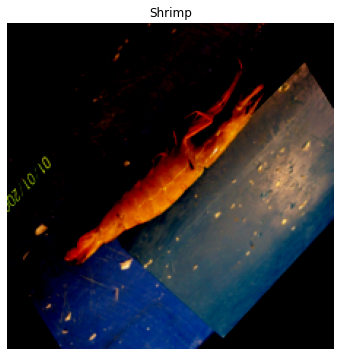

In [12]:
img, lab, img_name = dataset[4100]
plt.figure(figsize=(6, 6))
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(label_to_class[int(lab)])
plt.axis('off')
plt.show()

In [13]:
size = len(dataset)
print(f'Dataset size {size}')

Dataset size 9000


In [14]:
batch_size = 32
train_size = int(size * 0.8)
test_size = size - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=True)

In [15]:
batch_example = next(iter(train_loader))
print(f'Image batch size: {batch_example[0].shape}')
print(f'Label batch size: {batch_example[1].shape}')

Image batch size: torch.Size([32, 3, 224, 224])
Label batch size: torch.Size([32])


## Creating the Neural Network

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [17]:
def train(model, optimizer, criterion, epochs, train_loader, test_loader):
    loss_train, loss_test = [], []
    accuracy_train, accuracy_test = [], []

    for epoch in range(epochs):
        model.train()
        corrects = 0
        total = 0
        loss_list = []
        for images, labels, _ in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.max(outputs, 1)[1].to(DEVICE)

            total += len(labels)
            corrects += (predictions == labels).sum().item()
            loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        accuracy_train.append(100 * corrects / float(total))
        loss_train.append(np.mean(loss_list))

        model.eval()
        corrects = 0
        total = 0
        loss_list = []
        for images, labels, _ in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predict = torch.max(outputs.data, 1)[1].to(DEVICE)

            total += len(labels)
            corrects += (predict == labels).sum().item()
            loss_list.append(loss.item())

        accuracy_test.append(100 * corrects / float(total))
        loss_test.append(np.mean(loss_list))

        print(f"Epoch: {epoch + 1} | Train | Loss: {loss_train[-1]} | Accuracy: {accuracy_train[-1]}")
        print(f"Epoch: {epoch + 1} | Test | Loss: {loss_test[-1]} | Accuracy: {accuracy_test[-1]}\n")
    return accuracy_train, loss_train, accuracy_test, loss_test

### Simple CNN


In [18]:
class CNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(CNN, self).__init__()
        self.out_dim = out_dim
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 8, 8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=1, padding=0),
            nn.ReLU()
        )
        
        self.linear1 = nn.Linear(22 * 22 * 32, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, out_dim)
    
    def forward(self, x):
        conv = self.convs(x)
        flattened = conv.reshape(-1, 22 * 22 * 32)
        linear1 = F.relu(self.linear1(flattened))
        linear2 = self.linear2(linear1)
        out = self.linear3(linear2)
        return out

In [19]:
input_dim = dataset[0][0].shape[0] # number of channels (RGB - 3)
output_dim = len(classes) # number of classes
model = CNN(input_dim, output_dim).to(DEVICE)

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Запускать только при обучении моделей
# epochs = 8
# accuracy_train, loss_train, accuracy_test, loss_test = train(model, optimizer, criterion, epochs, train_loader, test_loader)

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1 | Train | Loss: 1.552904444800483 | Acuracy: 42.986111111111114
Epoch: 1 | Test | Loss: 1.0573864286405998 | Acuracy: 61.888888888888886



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2 | Train | Loss: 0.8701204329066806 | Acuracy: 69.11111111111111
Epoch: 2 | Test | Loss: 0.7525603572527567 | Acuracy: 73.33333333333333



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3 | Train | Loss: 0.6554621183872222 | Acuracy: 77.09722222222223
Epoch: 3 | Test | Loss: 0.6225471846890032 | Acuracy: 76.55555555555556



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 4 | Train | Loss: 0.5057403031322691 | Acuracy: 82.36111111111111
Epoch: 4 | Test | Loss: 0.5407470208511018 | Acuracy: 80.44444444444444



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 5 | Train | Loss: 0.393600450820393 | Acuracy: 86.40277777777777
Epoch: 5 | Test | Loss: 0.3792707888703597 | Acuracy: 86.11111111111111



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 6 | Train | Loss: 0.3016416627830929 | Acuracy: 90.04166666666667
Epoch: 6 | Test | Loss: 0.2990371893372452 | Acuracy: 88.66666666666667



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 7 | Train | Loss: 0.23072380271222856 | Acuracy: 92.27777777777777
Epoch: 7 | Test | Loss: 0.27766733825729606 | Acuracy: 90.0



  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 8 | Train | Loss: 0.1689727887014548 | Acuracy: 94.80555555555556
Epoch: 8 | Test | Loss: 0.22156471406158648 | Acuracy: 92.55555555555556



In [ ]:
# torch.save(model.state_dict(), 'simple_cnn.pth')

In [20]:
# Загрузка весов модели
url = 'https://drive.google.com/uc?id=1ENDvYnc0A4Z3CHwVooqSDdKL9wMmuzC9'
output = 'simple_cnn.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ENDvYnc0A4Z3CHwVooqSDdKL9wMmuzC9
To: /content/simple_cnn.pth
100%|██████████| 16.0M/16.0M [00:00<00:00, 80.4MB/s]


'simple_cnn.pth'

In [21]:
model.load_state_dict(torch.load('simple_cnn.pth'))
model.eval()

CNN(
  (convs): Sequential(
    (0): Conv2d(3, 8, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
  (linear1): Linear(in_features=15488, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=9, bias=True)
)

## Find required examples

In [22]:
true_label = []
predicted_label = []
probits = []
for sample in tqdm(test_set):
    image, label, _ = sample
    predict = F.softmax(model(image[None, ...].to(DEVICE)), dim=1)
    true_label.append(int(label))
    predicted_label.append(np.argmax(predict.cpu().detach().numpy()))
    probits.append(predict.cpu().cpu().detach().numpy())

  0%|          | 0/1800 [00:00<?, ?it/s]

In [23]:
index = np.arange(1800)
probits_arr = np.vstack(probits)
true_label_arr = np.vstack(true_label)
predicted_label_arr = np.vstack(predicted_label)

In [24]:
np.random.seed(42)

In [25]:
correctly_classified = (true_label_arr == predicted_label_arr).reshape(-1)
correct_prob = probits_arr[correctly_classified]
corr_index = index[correctly_classified]

sorted_prob = np.argsort(correct_prob.max(axis=1))
max_index_corr = corr_index[np.random.choice(sorted_prob[-300:], 2)]
min_index_corr = corr_index[np.random.choice(sorted_prob[:100], 2)]

In [26]:
incorrectly_classified = (true_label_arr != predicted_label_arr).reshape(-1)
incorrect_prob = probits_arr[incorrectly_classified]
incorr_index = index[incorrectly_classified]

sorted_prob = np.argsort(incorrect_prob.max(axis=1))
max_index_incorr = incorr_index[np.random.choice(sorted_prob[-300:], 2)]
min_index_incorr = incorr_index[np.random.choice(sorted_prob[:100], 2)]

In [27]:
# Нужные примеры достаем из test_set
test_set[max_index_corr[0]]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor(1),
 'Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/00629.png')

In [28]:
def print_examples(feature):
  for i in range(2):
    img, lab, img_name = test_set[feature[i]]
    image = Image.open(img_name)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.title(label_to_class[int(lab)])
    plt.axis('off')
    plt.show()

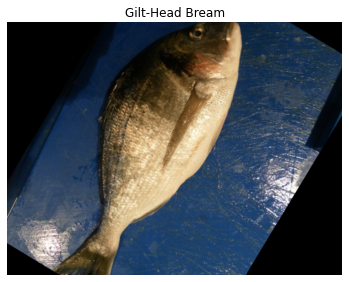

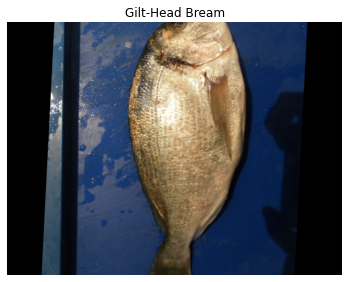

In [29]:
print_examples(max_index_corr)

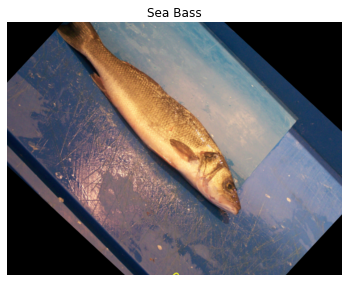

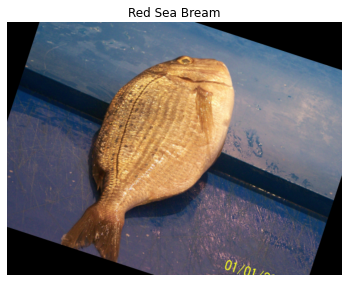

In [30]:
print_examples(max_index_incorr)